# Comparing DPNets to Nyström PCR/RRR

In [118]:
#General imports
import os
from pathlib import Path
import pickle
data_path = Path('data/')
from kooplearn._src.utils import topk
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'no-latex', 'std-colors'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

In [119]:
def pt_to_inch(pt):
    return pt/72.27

def figsize(wratio = 1, width_to_height = 3/2, text_width_pt = 397):
    w = pt_to_inch(text_width_pt)*wratio
    h = w/width_to_height
    return (w,h)

def sort_evd(evals, left_fns, right_fns):
    top_evals = topk(evals, len(evals))

    return np.where(top_evals.values > 0, top_evals.values, 0), left_fns[top_evals.indices], right_fns[top_evals.indices]

def implied_timescales(eigvals, lagtime = 0.2):
    return -lagtime/(np.log(np.abs(eigvals)))

## Loading DPNets Checkpoint

In [120]:
# Wrap the old code into kooplearn
import torch
import schnetpack
from kooplearn.models import DMD
from kooplearn.data import traj_to_contexts
import numpy as np
import matplotlib.pyplot as plt

class Namespace:
    def __init__(self, d):
        for k, v in d.items():
            if isinstance(v, dict):
                setattr(self, k, Namespace(v))
            else:
                setattr(self, k, v)
#Hardcoded configs              
configs = Namespace({
    'data': {
        'cutoff': 5
    },
    'network': {
        'n_rbf': 20,
        'n_atom_basis': 64,
        'n_final_features': 16,
        'n_interactions': 3
    }
})

class SchNet(schnetpack.model.AtomisticModel):
    def __init__(self, configs: Namespace):
        super().__init__(
            input_dtype_str="float32",
            postprocessors=None,
            do_postprocessing=False,
        )
        self.cutoff = configs.data.cutoff
        self.pwise_dist = schnetpack.atomistic.PairwiseDistances()
        self.radial_basis = schnetpack.nn.GaussianRBF(n_rbf=configs.network.n_rbf, cutoff=self.cutoff)
        self.net = schnetpack.representation.SchNet(
            n_atom_basis=configs.network.n_atom_basis, 
            n_interactions=configs.network.n_interactions,
            radial_basis=self.radial_basis,
            cutoff_fn=schnetpack.nn.CosineCutoff(self.cutoff)
        )
        self.final_lin = torch.nn.Linear(configs.network.n_atom_basis, configs.network.n_final_features)
        self.batch_norm = torch.nn.BatchNorm1d(configs.network.n_final_features, affine=False)
    def forward(self, inputs: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
        inputs = self.pwise_dist(inputs)
        inputs = self.net(inputs)
        inputs['scalar_representation'] = self.final_lin(inputs['scalar_representation'])
        return inputs['scalar_representation']

In [121]:
db_path = data_path / 'CLN025-0-protein-ALL.db'
cache_path = data_path / 'cache'
nb_list_transform = schnetpack.transform.CachedNeighborList(cache_path, schnetpack.transform.MatScipyNeighborList(cutoff=configs.data.cutoff), keep_cache=True)
in_transforms = [schnetpack.transform.CastTo32(), nb_list_transform]
dataset = schnetpack.data.ASEAtomsData(str(db_path), transforms=in_transforms)
dataloader = schnetpack.data.AtomsLoader(dataset, num_workers=2, persistent_workers=True, batch_size = 1, shuffle=False)

In [122]:
# Restoring checkpoint
state_dict = torch.load('schnet_model_ckpt.pt')
model = SchNet(configs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [123]:
# Pre-Compute pwise distances
from tqdm import tqdm
features = []
model.eval()
chunk_idx = 0
chunk_size = 20000
if False:
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        with torch.no_grad():
            feats = model(batch)
        features.append(feats)
        if (batch_idx + 1) % chunk_size == 0:
            features = torch.stack(features, dim=0)
            torch.save(features, f'data/schnet_feats/chunk_{chunk_idx}.pt')
            features = []
            chunk_idx += 1
    features = torch.stack(features, dim=0)
    torch.save(features, f'data/schnet_feats/chunk_{chunk_idx}.pt')

In [124]:
#Load the features back to memory
num_chunks = len(os.listdir("data/schnet_feats"))
features = []
for i in range(num_chunks):
    features.append(torch.load(f'data/schnet_feats/chunk_{i}.pt'))
features = torch.cat(features, dim=0)
#Use mean embedding as a pooling strategy
mean_embedding = torch.mean(features, dim=1)
mean_embedding = mean_embedding.numpy()

In [148]:
#Init report
report = {}
# Transfer operator fitting
contexts = traj_to_contexts(mean_embedding)
dmd_model = DMD(reduced_rank = False, rank = 16)
dmd_model = dmd_model.fit(contexts)
#Computing eigenvalue decomposition:
data = np.expand_dims(mean_embedding, 1) # (num_samples, 1, num_features)
eig, lf, rf = dmd_model.eig(eval_left_on = data, eval_right_on = data)
eig, lf, rf = sort_evd(eig, lf, rf)
#Populate report
report['DPNets'] = {
    'eigenvalues': eig,
    'left_fns': lf,
    'right_fns': rf
}
#Nystrom
for fname in os.listdir(data_path / 'nystrom_evd'):
    stub = fname.split('_')[0]
    with open(data_path / 'nystrom_evd' / fname, 'rb') as f:
        restored_obj = pickle.load(f)
        eig = restored_obj['eigenvalues']
        lf = restored_obj['left_eigenfunctions']
        rf = restored_obj['right_eigenfunctions']
    eig, lf, rf = sort_evd(eig, lf, rf)
    report["Nys-" + stub] = {
        'eigenvalues': eig,
        'left_fns': lf,
        'right_fns': rf
    }

Fitted DMD model. Lookback length set to 1


## Pretty print eigenvalues

In [149]:
timescales = {}
for model in report.keys():
    timescales[model] = implied_timescales(report[model]['eigenvalues'])

/tmp/ipykernel_3094101/710621774.py:15: RuntimeWarning: divide by zero encountered in log
  return -lagtime/(np.log(np.abs(eigvals)))


In [150]:
print("Implied Timescales (ns)")
print(tabulate(timescales, headers="keys", floatfmt=".2f"))

Implied Timescales (ns)
  DPNets    Nys-RRR    Nys-PCR
--------  ---------  ---------
  135.62      56.27      72.98
   17.59       0.89       5.27
    8.05       0.74       1.50
    3.83       0.01       0.84
    3.63       0.01       0.77
    3.62       0.01       0.71
    2.63       0.01       0.55
    2.33       0.00       0.50
    1.61       0.00       0.45
    1.51       0.00       0.41
    1.33       0.00       0.33
    1.30       0.00       0.22
    1.13       0.00       0.20
    1.08       0.00       0.19
    0.81       0.00       0.18
    0.57       0.00       0.08


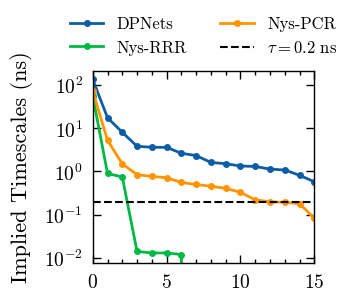

In [169]:
fig, ax = plt.subplots(figsize=figsize(wratio = .33, width_to_height = 1.1), dpi=200)
for model in report.keys():
    ax.plot(timescales[model], '.-', label=model)
ax.axhline(0.2, color='k', linestyle='--', lw=0.75, label=r'$\tau = 0.2$ ns')
ax.set_yscale('log')
ax.set_xmargin(0)
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=2, fontsize=6)
ax.set_ylabel('Implied Timescales (ns)')
ax.set_yticks([0.01, 0.1, 1, 10, 100])
fig.tight_layout()
fig.savefig("figures/implied_timescales.png")

## Free Energy Surface

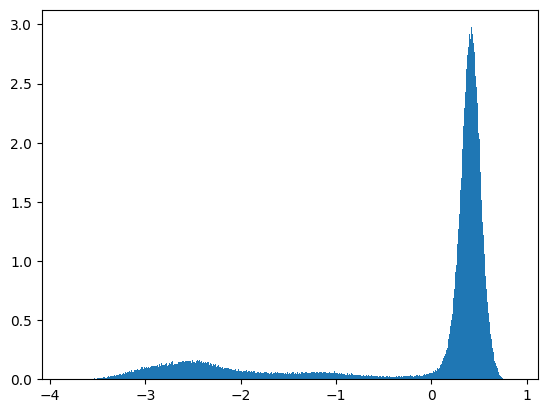

In [13]:
bins = 1000
plt.hist(lf[:, -2], bins = bins, density=True);

In [15]:
dmd_model.eig().sum()

(14.282188+0j)

In [14]:
print(implied_timescales(dmd_model.eig(), dt))

[  0.57381463   0.8120724    1.0774456    1.1300983    1.3021536
   1.3344892    1.5089793    1.6097833    2.3308525    2.6301708
   3.6168768    3.6283338    3.827861     8.052493    17.593748
 135.6215    ]


# Nystrom Models

In [1]:
import os
os.environ["CUDA_PATH"] = "/home/novelli/anaconda3/envs/nyskoop"
import numpy as np
import torch
pwdist = np.load("/home/novelli/dp_examples/chignolin/data/CLN025_heavy_pwisedist.npy")
pwdist = torch.from_numpy(pwdist)
# Data Normalization
feature_norm = torch.linalg.norm(pwdist, dim=0, keepdim=True)
feature_mean = torch.mean(pwdist, dim=0, keepdim=True)
pwdist -= feature_mean
pwdist /= feature_norm

In [2]:
import pickle
nystrom_models = {}
for model in ['pcr','rrr']:
    with open(f'ckpt/nystrom_{model}.pkl', 'rb') as f:
        nystrom_models[model] = pickle.load(f)

In [3]:
for model in ['pcr','rrr']:
    est = nystrom_models[model]['estimator']
    v, lf_fn, r_fn = est.eigenfunctions()
    v = v.resolve_conj().numpy()
    lf = lf_fn(pwdist).numpy()
    rf = r_fn(pwdist).numpy()
    sort_perm = np.argsort(v)[::-1]
    np.savez(f'data/nystrom_evd/{model}.npz', eigenvalues=v[sort_perm], left_fns=lf[:, sort_perm], right_fns=rf[:, sort_perm])

In [8]:
v, lf_fn, r_fn = est.eigenfunctions()

In [3]:
np.argsort(np.arange(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
lf = lf_fn(pwdist)

In [13]:
lf = lf.numpy()

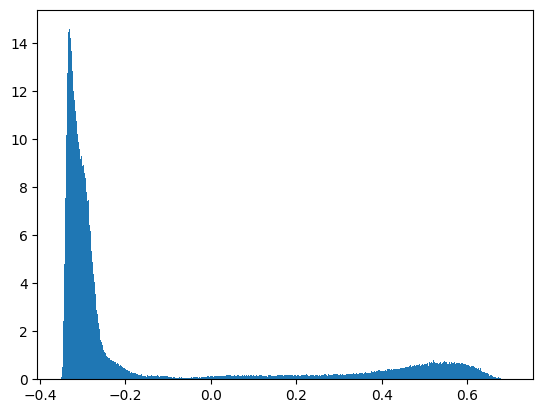

In [16]:
import matplotlib.pyplot as plt
plt.hist(lf[:, 1].real, bins = 1000, density=True);

In [19]:
print(implied_timescales(v.resolve_conj().numpy(), dt))

[95.838295    7.5872793   1.1889821   1.1159911   0.8237654   0.7524317
  0.6694608   0.58439004  0.44238803  0.39537108  0.3649637   0.3305681
  0.30275244  0.24980013  0.22199486  0.21354909]
